In [73]:
# Imports
import pykep as pk
import pygmo as pg
import numpy as np
import matplotlib.pyplot as plt
from matts_bug_fix import *

In [74]:
# We define the optimization problem
udp = matts_pl2pl_N_impulses(
    start = pk.planet.jpl_lp('earth'),
    target = pk.planet.jpl_lp('mars'),
    N_max = 3,
    tof = [100., 1000.],
    vinf = [0., 4],
    phase_free = False,
    multi_objective = False,
    t0 = [pk.epoch(7400), pk.epoch(7700)])

# All pykep problems in the module trajopt are compatible with pygmo.
# So we create a pygmo problem from the pykep udp (User Defined Problem)
prob = pg.problem(udp)

In [75]:
prob

Problem name: <class 'matts_bug_fix.matts_pl2pl_N_impulses'>
	Global dimension:			7
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [7400, 100, 0.001, 0, 0, ... ]
	Upper bounds: [7700, 1000, 0.999, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

In [76]:
# Here we define the solution strategy, which in this simple case is to use
# Covariance Matrix adaptation Evolutionary Strategy (CMA-ES)
uda = pg.cmaes(gen=1000, force_bounds = True)
algo = pg.algorithm(uda)

# Here we activate some degree of screen output (will only show in the terminal)
algo.set_verbosity(10)

# We construct a random population of 20 individuals (the initial guess)
pop = pg.population(prob, size = 10, seed = 123)

# We solve the problem
pop = algo.evolve(pop)

In [77]:
pop.champion_x

array([7.47591450e+03, 4.34783682e+02, 5.32143193e-01, 0.00000000e+00,
       5.50564527e-01, 2.62030405e+03, 3.82082656e-01])

In [78]:
epoch(pop.champion_x[0])

2020-Jun-19 21:56:53.049590

In [79]:
T = pk.planet.jpl_lp('mars').compute_period(epoch(pop.champion_x[0])) * SEC2DAY
N = 60
when = np.linspace(0, T, N)

In [80]:
x = np.array([0.0] * N)
y = np.array([0.0] * N)
z = np.array([0.0] * N)

In [81]:
r, v = pk.planet.jpl_lp('mars').eph(epoch(epoch(pop.champion_x[0]).mjd2000 + day))

In [82]:
for i, day in enumerate(when):
    r, v = pk.planet.jpl_lp('mars').eph(epoch(epoch(pop.champion_x[0]).mjd2000 + day))
    x[i] = r[0] / AU
    y[i] = r[1] / AU
    z[i] = r[2] / AU

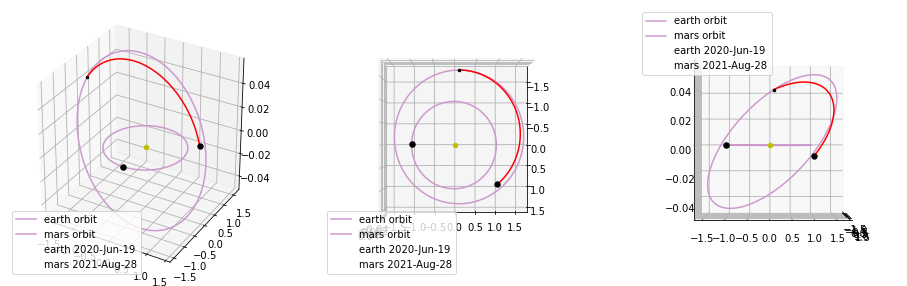

In [83]:
# Plot our trajectory
fig = plt.figure(figsize = (16,5))


ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')


ax1 = udp.plot(pop.champion_x, axes = ax1)

ax2 = udp.plot(pop.champion_x, axes = ax2)
ax2.view_init(elev=90, azim=0)

ax3 = udp.plot(pop.champion_x, axes = ax3)
ax3.view_init(elev=0, azim=0)

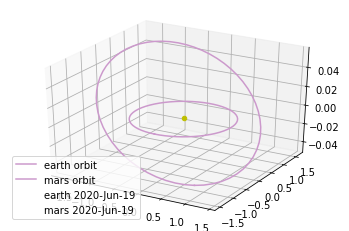

In [85]:
from pykep.orbit_plots import plot_planet, plot_lambert, plot_kepler

    
fig = plt.figure()
axes = fig.gca(projection='3d')

# Sun
axes.scatter(0, 0, 0, color='y')

# Planet 1
plot_planet(jpl_lp('earth'), t0 = epoch(pop.champion_x[0]),
            color = (0.8, 0.6, 0.8), legend = (True, True),
            units = AU, axes = axes, s = 0)

# Planet 2
plot_planet(jpl_lp('mars'), t0 = epoch(pop.champion_x[0]),
            color = (0.8, 0.6, 0.8), legend = (True, True),
            units = AU, axes = axes, s = 0)

In [94]:
pk.planet.jpl_lp('mars')

Planet Name: mars
Own gravity parameter: 42828000000000
Central body gravity parameter: 1.32712440018e+20
Planet radius: 3397000
Planet safe radius: 3736700.0000000005
Ephemerides type: JPL low-precision

## Plot a planet and its orbit with plotly

In [108]:
def get_orbit(planet, day):

    planet = pk.planet.jpl_lp(planet)
    epoch_ = epoch(day)

    T = planet.compute_period(epoch_) * SEC2DAY
    N = 300
    when = np.linspace(0, T, N)

    x = np.array([0.0] * N)
    y = np.array([0.0] * N)
    z = np.array([0.0] * N)

    for i, day in enumerate(when):
        r, v = planet.eph(epoch(epoch_.mjd2000 + day))
        x[i] = r[0] / AU
        y[i] = r[1] / AU
        z[i] = r[2] / AU

    return x, y, z

e_x, e_y, e_z = get_orbit('earth', 7400)
m_x, m_y, m_z = get_orbit('mars', 7400)
j_x, j_y, j_z = get_orbit('jupiter', 7400)

In [124]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Scatter3d(
    x=e_x,
    y=e_y,
    z=e_z,
    marker=dict(
        size=.1,
        color= '#42B3EF',
    ),
    )])

fig.add_trace(go.Scatter3d(
    x=m_x,
    y=m_y,
    z=m_z,
    opacity=0.5,
    marker=dict(
        size=.1,
        color= '#DA5C2E',
    ),
    ))

fig.add_trace(go.Scatter3d(
    x=j_x,
    y=j_y,
    z=j_z,
    opacity=0.5,
    marker=dict(
        size=.1,
        color= '#F89B10',
    ),
    ))

fig.add_trace(go.Scatter3d(
    x=[j_x[0]],
    y=[j_y[0]],
    z=[j_z[0]],
    opacity=1,
    marker=dict(
        size=5,
        color= '#F89B10',
    ),
    ))

fig.add_trace(go.Scatter3d(
    x=[e_x[0]],
    y=[e_y[0]],
    z=[e_z[0]],
    opacity=1,
    marker=dict(
        size=3,
        color= '#42B3EF',
    ),
    ))

fig.add_trace(go.Scatter3d(
    x=[m_x[0]],
    y=[m_y[0]],
    z=[m_z[0]],
    opacity=1,
    marker=dict(
        size=2,
        color= '#DA5C2E',
    ),
    ))

fig.add_trace(go.Scatter3d(
    x=[0],
    y=[0],
    z=[0],
    opacity=1,
    marker=dict(
        size=7,
        color= '#ECEF42',
    ),
    ))

fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[-6,6],),
                     yaxis = dict(nticks=4, range=[-6,6],),
                     zaxis = dict(nticks=4, range=[-1,1],),))


fig.update_layout(scene = dict(
                    xaxis = dict(
                         backgroundcolor="black",
                         gridcolor="black",
                         showbackground=True,
                         zerolinecolor="black",),
                    yaxis = dict(
                        backgroundcolor="black",
                        gridcolor="black",
                        showbackground=True,
                        zerolinecolor="black"),
                    zaxis = dict(
                        backgroundcolor="black",
                        gridcolor="black",
                        showbackground=True,
                        zerolinecolor="black",),),
                  )

fig.show()

In [126]:
plnts = {'murcury':'#hfhh', 'venus':'#uufuh',}

for planet in plnts:
    print(planet)
    print(plnts[planet])

murcury
#hfhh
venus
#uufuh


In [137]:
epoch_ = epoch(7400)
planet = pk.planet.jpl_lp('neptune')
r, v = planet.eph(epoch(epoch_.mjd2000 + day))

In [139]:
epoch_.mjd2000

7400.0

In [141]:
def get_orbit(planet, date):

    planet = pk.planet.jpl_lp(planet)
    epoch_ = epoch(date)

    T = planet.compute_period(epoch_) * SEC2DAY
    N = 40
    when = np.linspace(0, T, N)

    x = np.array([0.0] * N)
    y = np.array([0.0] * N)
    z = np.array([0.0] * N)

    for i, day in enumerate(when):
        r, v = planet.eph(epoch(date + day))
        x[i] = r[0] / AU
        y[i] = r[1] / AU
        z[i] = r[2] / AU

    return [x, y, z]

In [142]:
def get_plot_data(day):
    return_dict = {}

    plnts = {'mercury': '#7C7C7C',
             'venus': '#DFE0A8',
             'earth': '#42B3EF',
             'mars': '#DA5C2E',
             'jupiter': '#F89B10',
             'saturn': '#E3CA4E',
             #'uranus': '#37EBE2',
             #'neptune': '#3740EB'
             }

    for planet in plnts:
        orb_data = get_orbit(planet, day)
        return_dict[planet] = {
        'orbit':{'x':orb_data[0], 'y':orb_data[1], 'z':orb_data[2]},
        'position':{'x':[orb_data[0][0]], 'y':[orb_data[1][0]], 'z':[orb_data[2][0]]},
        'color': plnts[planet]}

    return return_dict

In [143]:
planets = get_plot_data(day)

In [147]:
fig_frames = []

In [148]:
for k in range(40):
    fig_frames.append(go.Frame(data=[
    go.Scatter3d(
                    x = [planets[planet]['orbit']['x'][k]],
                    y = [planets[planet]['orbit']['y'][k]],
                    z = [planets[planet]['orbit']['z'][k]],
                    marker = dict(
                        size = 5,
                        color = planets[planet]['color'],
                    )
    ) for planet in planets]))

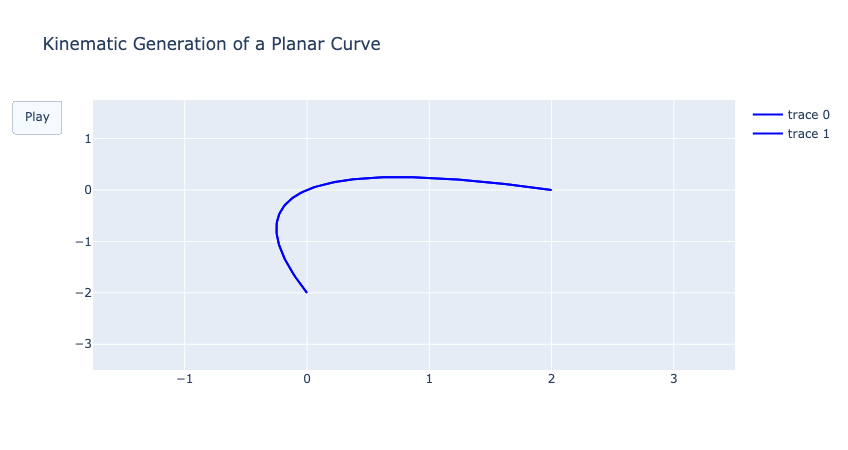

In [152]:
import plotly.graph_objects as go

import numpy as np

# Generate curve data
t = np.linspace(-1, 1, 100)
x = t + t ** 2
y = t - t ** 2
xm = np.min(x) - 1.5
xM = np.max(x) + 1.5
ym = np.min(y) - 1.5
yM = np.max(y) + 1.5
N = 50
s = np.linspace(-1, 1, N)
xx = s + s ** 2
yy = s - s ** 2


# Create figure
fig = go.Figure(
    data=[go.Scatter(x=x, y=y,
                     mode="lines",
                     line=dict(width=2, color="blue")),
          go.Scatter(x=x, y=y,
                     mode="lines",
                     line=dict(width=2, color="blue"))],
    layout=go.Layout(
        xaxis=dict(range=[xm, xM], autorange=False, zeroline=False),
        yaxis=dict(range=[ym, yM], autorange=False, zeroline=False),
        title_text="Kinematic Generation of a Planar Curve", hovermode="closest",
        updatemenus=[dict(type="buttons",
                          buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None])])]),
    frames=[go.Frame(
        data=[go.Scatter(
            x=[xx[k]],
            y=[yy[k]],
            mode="markers",
            marker=dict(color="red", size=10))])

        for k in range(N)]
)

fig.show()

In [155]:
import copy
old_list = [0, 1, 3]
new_list = copy.deepcopy(old_list)
new_list + old_list

[0, 1, 3, 0, 1, 3]